In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [2]:
image_size=256
batch_size=32

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size=(image_size,image_size),
batch_size=batch_size)

Found 2152 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [16]:
len(dataset) #length=68 mean 68 batches of 32 images per batch

68

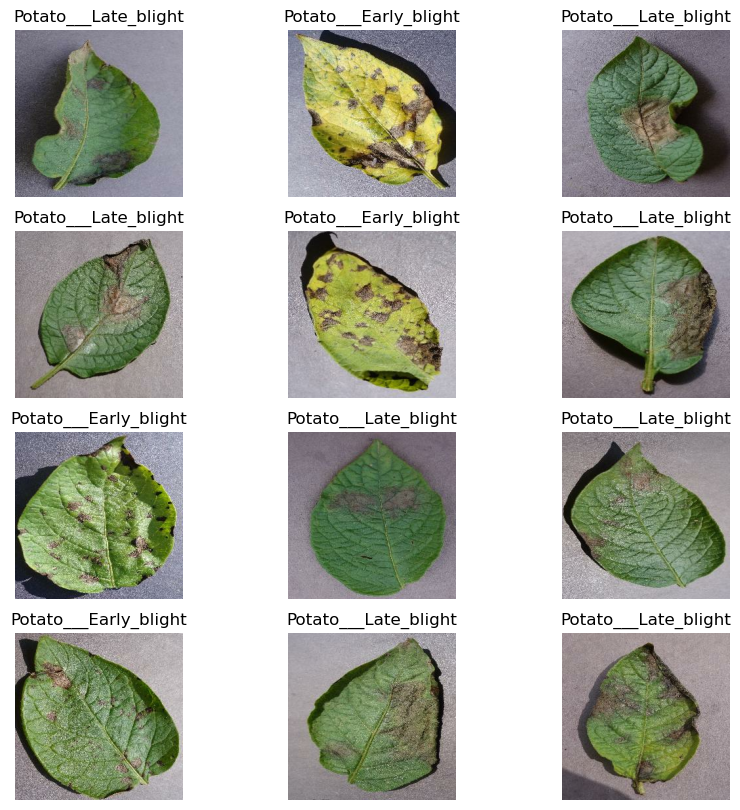

In [15]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype(int))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

### Splitting dataset using .take()

In [17]:
#80% -> training
#20% -> 10% validation and 10% test

In [42]:
def get_dataset_partion(df, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    df_size=len(df)
    
    if shuffle:
        df=df.shuffle(shuffle_size,seed=12)
    
    a=int(train_size*df_size)
    train=df.take(a)
    
    test=df.skip(a)
    
    b=int(val_size*df_size)
    
    val=test.take(b)
    test=test.skip(b)
    
    return train, val, test
    

In [43]:
train, val, test=get_dataset_partion(dataset)

In [44]:
len(train),len(val),len(test)

(54, 6, 8)

In [46]:
train=train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val=val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test=test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
#Normalization
resize_rescale=tf.keras.Sequential([
    layers.Resizing(image_size,image_size), #this layer is if any new data is added for testing purpose then that data has to be of same image size on which model's trained
    layers.Rescaling(1.0/255)
])

In [51]:
#Augmentation
data_aug=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [68]:
model=models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32,(3,3),activation='relu', input_shape=(batch_size, image_size,image_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(3, activation='softmax')
])

In [69]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [70]:
model.summary

<bound method Model.summary of <Sequential name=sequential_4, built=False>>

In [71]:
his=model.fit(train,
             epochs=50,
             batch_size=32,
             verbose=1,
             validation_data=val
             )

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.4968 - loss: 0.9401 - val_accuracy: 0.6198 - val_loss: 0.8208
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6947 - loss: 0.7171 - val_accuracy: 0.8073 - val_loss: 0.4791
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8141 - loss: 0.4325 - val_accuracy: 0.9219 - val_loss: 0.2693
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8749 - loss: 0.3012 - val_accuracy: 0.8594 - val_loss: 0.3198
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9006 - loss: 0.2725 - val_accuracy: 0.9010 - val_loss: 0.2597
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9280 - loss: 0.2171 - val_accuracy: 0.9271 - val_loss: 0.1899
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9297 - loss: 0.1697 - val_accuracy: 0.8490 - val_loss: 0.3754
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9196 - loss: 0.2148 - val_accuracy: 0.9583 - val_loss

In [72]:
score=model.evaluate(test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.9791 - loss: 0.0420


In [75]:
score

[0.026764795184135437, 0.98828125]

In [78]:
acc=his.history['accuracy']
val_acc=his.history['val_accuracy']

loss = his.history['loss']
val_loss = his.history['val_loss']

In [80]:
EPOCHS=50

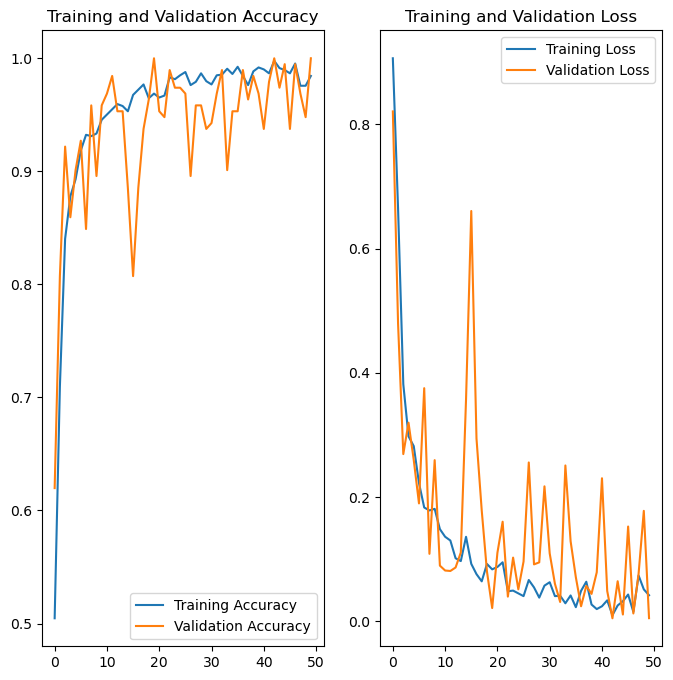

In [81]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
predicted label: Potato___Late_blight


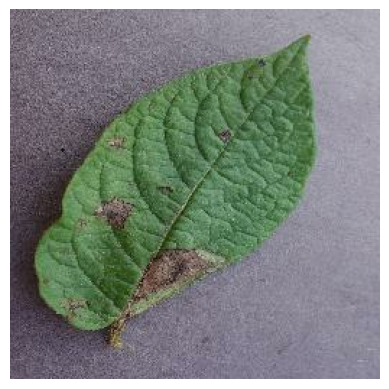

In [86]:
#run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [91]:
#Prediction using function
def predict(model, img):
    imgarray=tf.keras.preprocessing.image.img_to_array(images[1].numpy())
    imgarray=tf.expand_dims(imgarray,0) #create a batch
    
    prediction=model.predict(imgarray)
    
    predicted_class=class_names[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


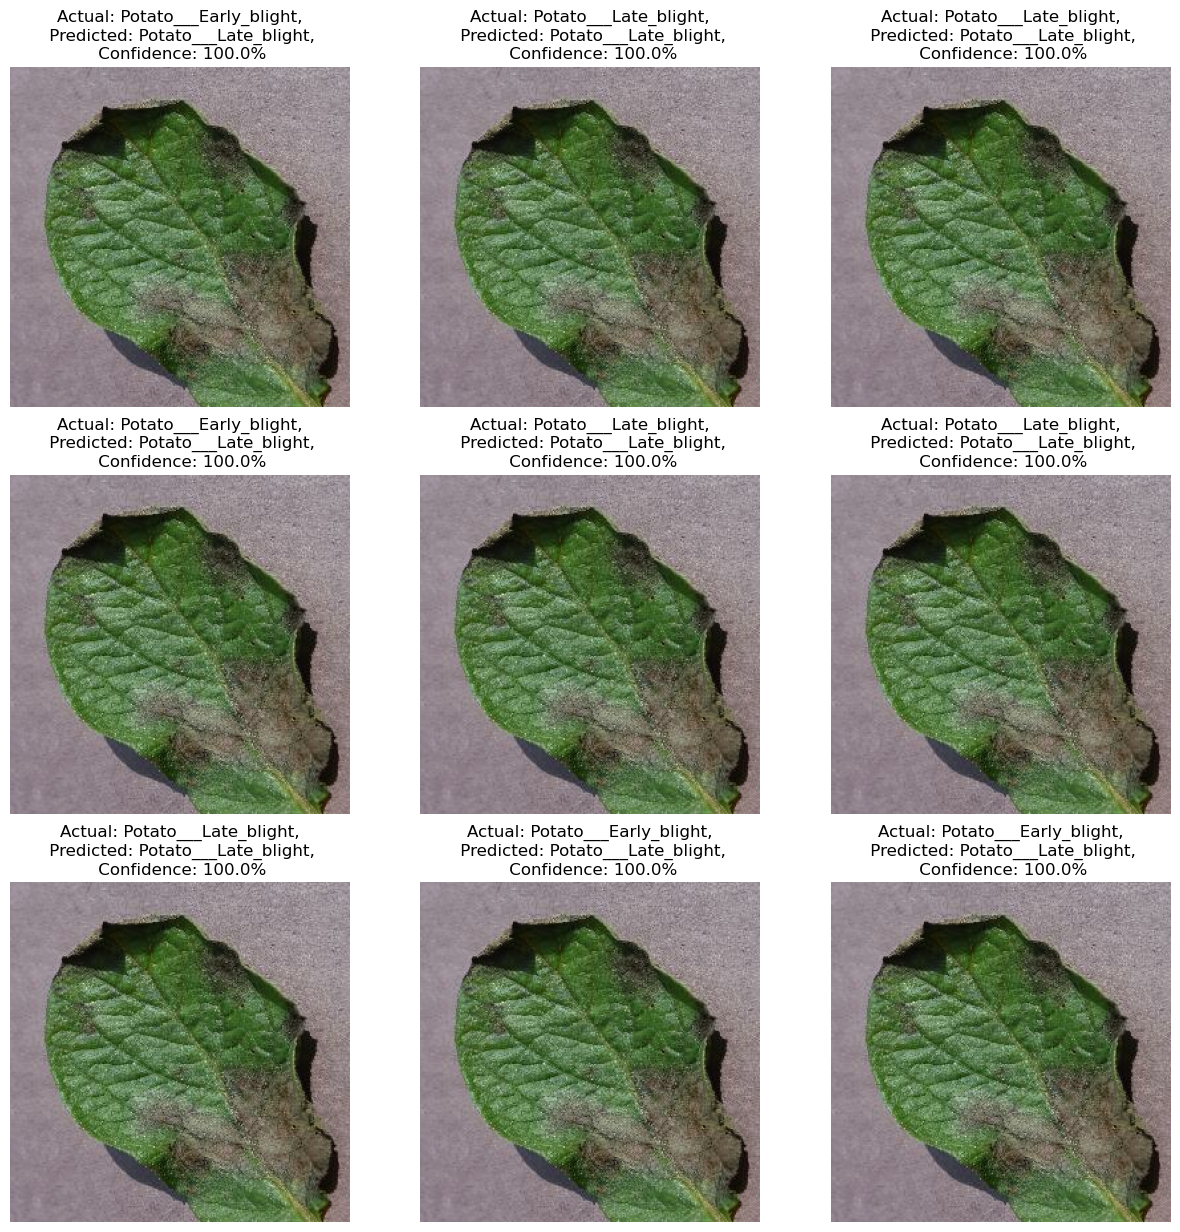

In [94]:
plt.figure(figsize=(15,15))
for images, label in test.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[1].numpy().astype("int"))
        
        predicted_class, confidence =predict(model, images[1].numpy())
        actual_class=class_names[label[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        
        plt.axis("off")

### model version and model save

In [106]:
import os
model_version=1
model_directory = "models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)


In [107]:
model.save(f"models/{model_version}.keras")